In [2]:
import sys
sys.path.append("../../../src")

from mask_dataset import MaskedDataset
from mask_dataset import MaskedDataset
from probe_evaluation import draw_active_neuron_heatmap
from prober import Prober
import numpy as np

dataset = MaskedDataset(model_name='mbert')
prober = Prober(dataset, device='cuda:4')

Load pre-saved file /home/xzhao/workspace/probing-mulitlingual/result/dataset-mbert/mlama-dataset.pkl for MaskedDataset instance


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Define neuron similarity metrics
from scipy.stats import spearmanr, kendalltau
def measure_neuron_similarity(neuron_rank1, neuron_rank2, topk=100, method='shared_neuron'):
    neuron_rank1 = neuron_rank1[:topk]
    neuron_rank2 = neuron_rank2[:topk]
    if method == "shared_neuron":
        unions = set(neuron_rank1).union(set(neuron_rank2))
        corr = len(set(neuron_rank1).intersection(set(neuron_rank2))) / len(unions)
    elif method == "spearmanr":
        corr, _ = spearmanr(neuron_rank1, neuron_rank2)
    elif method == "kendalltau":
        corr, _ = kendalltau(neuron_rank1, neuron_rank2)
    return round(corr, 4)


In [4]:
# Get top-30 languages by p1 score ranking
from pred_evaluation import calculate_overall_p1_score_standard
lang2p1 = calculate_overall_p1_score_standard(dataset)
sorted_langs = sorted(lang2p1, key=lambda k: lang2p1[k], reverse=True)
sorted_langs = sorted_langs[:30]
print(sorted_langs)

['en', 'id', 'it', 'de', 'es', 'nl', 'pt', 'ca', 'tr', 'da', 'ms', 'sv', 'fr', 'af', 'ro', 'vi', 'gl', 'fa', 'cy', 'el', 'he', 'ko', 'zh', 'pl', 'ar', 'hu', 'hr', 'cs', 'ceb', 'et']


In [5]:
from tqdm import tqdm
topk = 100
uuid2lang2topk_neurons = {}
for lang, rel in tqdm(dataset.lang_rel_iter(cand_langs=sorted_langs)):
    *_, probing_result = prober.probe_uuid_by_lang_rel(lang, rel, cand_size=10000)
    if probing_result[1] is None:
        continue
    for uuid in probing_result[1]:
        uuid2lang2topk_neurons.setdefault(uuid, {}).update({lang: probing_result[1][uuid][:topk]})

1270it [01:23, 15.23it/s]


In [6]:
import itertools
topk = 50
dists = np.zeros((30, 30))
for lang1, lang2 in tqdm(itertools.combinations(sorted_langs, 2)):
    corrs_topk = []
    for uuid in uuid2lang2topk_neurons:
        if lang1 in uuid2lang2topk_neurons[uuid] and lang2 in uuid2lang2topk_neurons[uuid]:
            corrs_topk.append(measure_neuron_similarity(uuid2lang2topk_neurons[uuid][lang1][:topk], uuid2lang2topk_neurons[uuid][lang2][:topk], method='shared_neuron'))
    corr = np.mean(corrs_topk)
    dists[sorted_langs.index(lang1)][sorted_langs.index(lang2)] = corr
    dists[sorted_langs.index(lang2)][sorted_langs.index(lang1)] = corr

0it [00:00, ?it/s]

435it [00:04, 87.30it/s] 


In [7]:
import kmedoids
clusters = 5
c = kmedoids.fasterpam(1 - dists, clusters)
groups = []
for i in range(clusters):
    index = np.where(c.labels==i)[0].tolist()
    print(" ".join([dataset.display_lang(sorted_langs[idx]) for idx in index]))
    groups.append(index)

id-Indonesian ms-Malay vi-Vietnamese fa-Persian
it-Italian ro-Romanian pl-Polish
de-German tr-Turkish zh-Chinese hu-Hungarian hr-Croatian ceb-Cebuano
es-Spanish nl-Dutch pt-Portuguese ca-Catalan da-Danish sv-Swedish fr-French af-Afrikaans gl-Galician cy-Welsh el-Greek he-Hebrew ko-Korean ar-Arabic cs-Czech et-Estonian
en-English


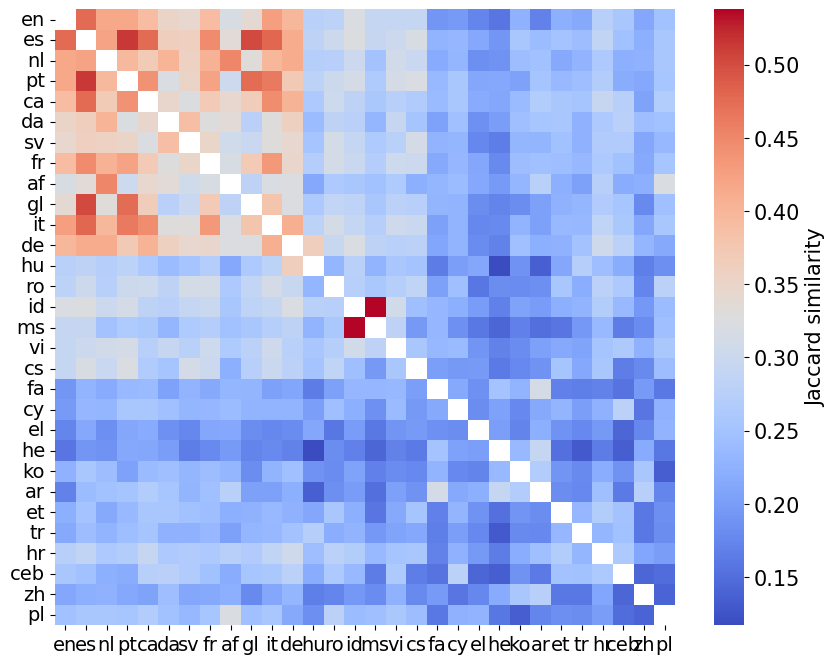

In [16]:
import matplotlib.patches as patches
import copy 
import matplotlib.pyplot as plt

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True


dists_for_plot = dists.copy()
sorted_langs_for_plot = copy.deepcopy(sorted_langs)
langs_by_family = [
    'en', 'de', 'nl', 'da',
    'id', 'ms', 'vi', 
    'pl', 'cs', 'hu']
langs_by_family = [
    'en', 
    'es', 'nl', 'pt', 'ca', 'da', 'sv', 'fr', 'af', 'gl', 'it', 'de', 'hu', 'ro',
    'id', 'ms', 'vi', 'cs',  'fa', 
    'cy', 'el', 'he', 'ko', 'ar', 'et',
    'tr', 'hr', 'ceb', 'zh', 'pl']
lbf_idx = [sorted_langs_for_plot.index(lang) for lang in langs_by_family]
dists_for_plot = dists_for_plot[np.ix_(lbf_idx, lbf_idx)]
# dists_for_plot = 1 - reidx_dists
sorted_langs_for_plot = langs_by_family

sort = False
if sort:
    reidx = np.argsort(dists_for_plot[sorted_langs_for_plot.index('en')])[::-1]
    langs = [sorted_langs_for_plot[idx] for idx in reidx]
    dists_for_plot_for_plot = dists_for_plot[reidx, :][:, reidx]

import matplotlib.pyplot as plt
import seaborn as sns

np.fill_diagonal(dists_for_plot, np.nan)
fig, ax = plt.subplots(figsize=(10,8))
# langs_name = [dataset.display_lang(lang, prefix=False) for lang in sorted_langs_for_plot]
langs_name = [lang for lang in sorted_langs_for_plot]
g = sns.heatmap(dists_for_plot, cmap="coolwarm", xticklabels=langs_name, yticklabels=langs_name, ax=ax) # type: ignore

ax.set_xticklabels(langs_name, fontsize=14)
ax.set_yticklabels(langs_name, fontsize=14, rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)  # set the tick labels font size
cbar.set_label('Jaccard similarity', size=15)  # set the colorbar label font size
# plt.title("Distance of languages measured by shared factual knowledge", fontsize=18)
# ax.set_title("Distance of languages measured by shared active neurons", y=1.05, fontsize=18)
plt.savefig("../../display/figures/lang_pairwise_dist_by_shared_neurons.updated.eps", format="eps", bbox_inches="tight", pad_inches=0.1)

In [9]:
print(dists[0][sorted_langs.index('zh')])
print(dists.mean())

0.21099313471502593
0.2461287925522409


In [10]:
lang1 = 'en'
lang2 = 'zh'
uuid2corr = {}
for uuid in uuid2lang2topk_neurons:
    if lang1 in uuid2lang2topk_neurons[uuid] and lang2 in uuid2lang2topk_neurons[uuid]:
        uuid2corr[uuid] = measure_neuron_similarity(uuid2lang2topk_neurons[uuid][lang1][:topk], uuid2lang2topk_neurons[uuid][lang2][:topk], method='shared_neuron')
top_common_uuids = sorted(uuid2corr, key=lambda k: uuid2corr[k], reverse=True)[:100]
